In [2]:
import geopandas as gpd
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.visualization import ee_viz
from src.data import mtbs
from src.data import shape_processor
from src.data import gedi_pipeline
from src.data import k_nn
import ee
import scipy.stats as stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from fitter import Fitter, get_common_distributions, get_distributions
from src.processing.recent_fires import gedi_matching, matching_analysis
from src.visualization.gedi_viz import geo_plot

import importlib
importlib.reload(gedi_pipeline)
importlib.reload(gedi_matching)
importlib.reload(matching_analysis)
from src.data.gedi_pipeline import get_severity

2023-06-08 11:15:48,936 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


In [2]:
ee.Authenticate()


Successfully saved authorization token.


In [3]:
ee.Initialize()

In [4]:
sierras = gpd.read_file("../../../data/shapefiles/sierras_convex_hull.shp")
firep_db = FirePerimetersDB('../../../data/fire_perimeters.gdb/')
sierra_firep = FirePerimeters(firep_db).filter_for_years(['2020']).filter_within_geometry(sierras)

In [5]:
gedi_gdf= gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/sierras_matched_lc_all_2x2.csv')
gedi_burned, gedi_unburned = gedi_pipeline.process_gedi_shots_for_recent_fires_analysis(gedi_gdf)

2023-06-08 11:32:38,124 DEBUG: Excluded shots on the burn boundaries, shots remaining:         9446235 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-08 11:32:39,425 DEBUG: Number of GEDI shots that burned at least once:                  1440937 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-08 11:32:43,400 DEBUG: Number of GEDI shots that never burned since 1984:         7852535 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:70]
2023-06-08 11:32:44,470 DEBUG: Number of shots that burned exactly once:                    1253729 [in exclude_shots_on_burn_boundaries at /home/jk871/fire-regen/src/data/gedi_pipeline.py:86]
2023-06-08 11:32:45,186 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    771977 [in exclude_shots_on_burn_b

In [6]:
gedi_l2b = gedi_pipeline.get_gedi_as_gdp('/maps/fire-regen/data/gedi_l2b_sierras_matched_lc_all_2x2.csv')
gedi_burned_l2b, gedi_unburned_l2b = gedi_pipeline.process_gedi_shots_for_recent_fires_analysis(gedi_l2b)

2023-06-08 11:39:56,702 DEBUG: Excluded shots on the burn boundaries, shots remaining:         14968077 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:58]
2023-06-08 11:39:57,241 DEBUG: Number of GEDI shots that burned at least once:                  2184975 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:63]
2023-06-08 11:39:59,783 DEBUG: Number of GEDI shots that never burned since 1984:         12539296 [in divide_shots_into_burned_and_unburned at /home/jk871/fire-regen/src/data/gedi_pipeline.py:70]
2023-06-08 11:40:00,734 DEBUG: Number of shots that burned exactly once:                    1891695 [in exclude_shots_on_burn_boundaries at /home/jk871/fire-regen/src/data/gedi_pipeline.py:86]
2023-06-08 11:40:01,054 DEBUG: Number of GEDI shots that have a perfect match with burn                    raster (all 2x2 pixels have the same severity):                    1192212 [in exclude_shots_on_bur

In [7]:
fire = sierra_firep.get_fire('CREEK')

In [8]:
matches = gedi_matching.match_measurements_before_and_after_fire(fire, gedi_burned, 'agbd')

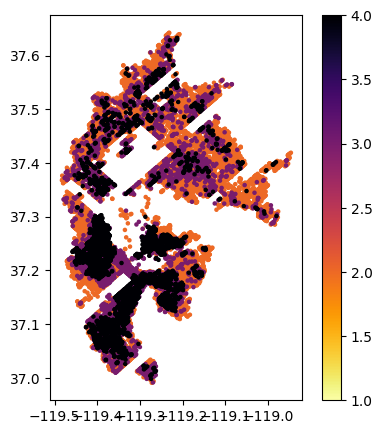

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
geo_plot(matches, ax, 'burn_severity_median', vmin=1, vmax=4)

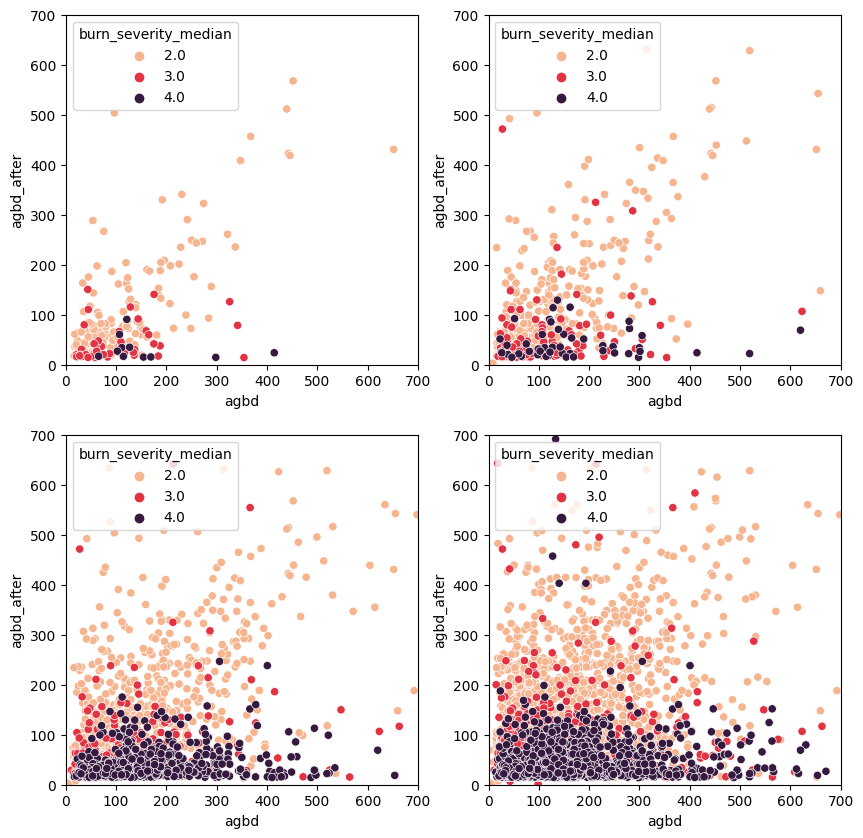

In [46]:
matching_analysis.plot_severity_for_distance(matches, 'agbd')

/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/sklearn/metrics/_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


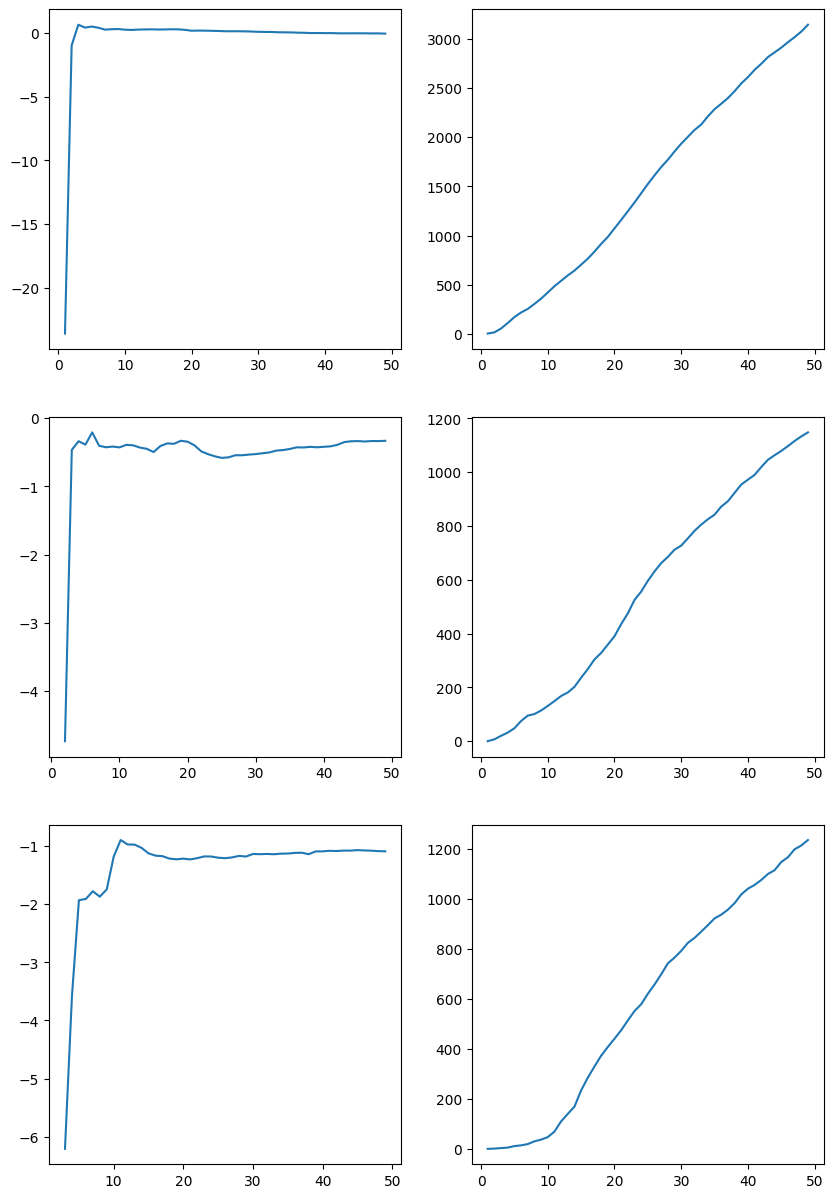

In [13]:
matching_analysis.plot_error_for_distances(matches, 'agbd')

In [19]:
def filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1) & (df.pft_class == 1)]

In [20]:
close_matches = filter_land_cover(matches[matches.closest_distance < 20])

Linear regression fit for severity 2.
Best Linear regression coefficient is [0.76839189].         R squared is : 0.44222642240739196.
The error for coeff = 1 is: 0.20126103832761366.
Linear regression fit for severity 3.
Best Linear regression coefficient is [0.15712977].         R squared is : 0.04842290946295491.
The error for coeff = 1 is: -0.5046095812411413.
Linear regression fit for severity 4.
Best Linear regression coefficient is [0.00444276].         R squared is : 0.0003372850982684694.
The error for coeff = 1 is: -1.1809920065890869.


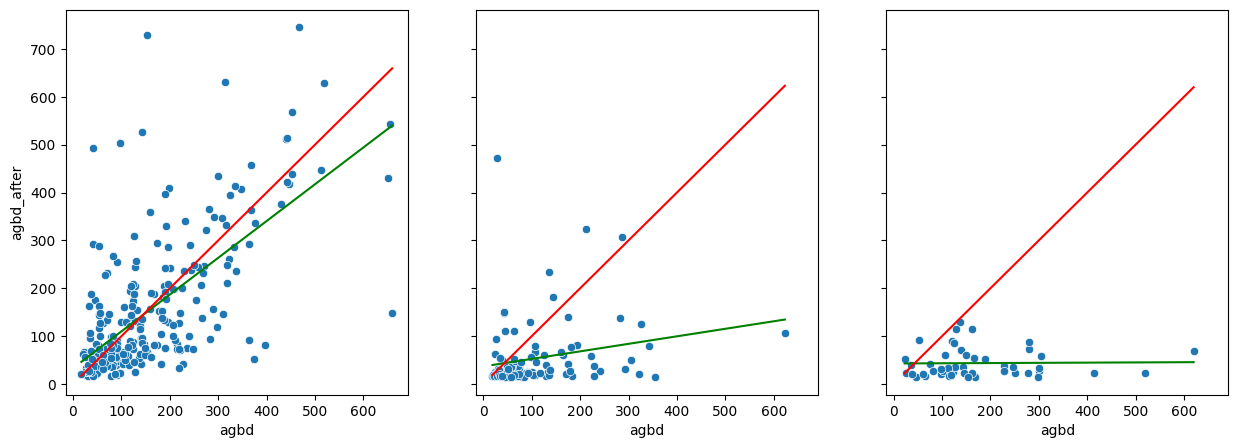

In [16]:
matching_analysis.fit_linear_regression_per_severity(close_matches, 'agbd')

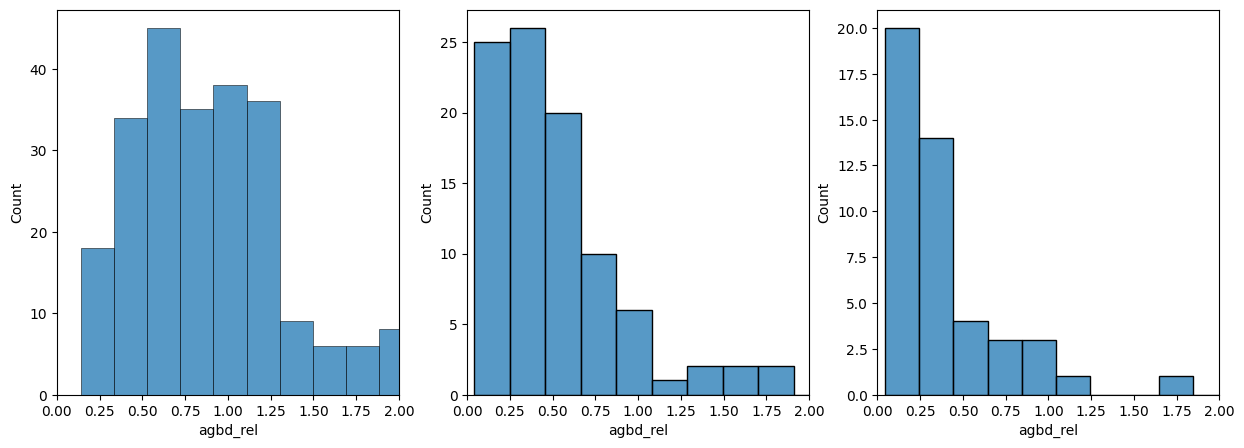

In [17]:
matching_analysis.plot_rel_difference_per_severity(close_matches, 'agbd')

A lot of low severity seems misclassified.

### Fit distribution

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  5.52it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
beta            0.000112  1982.625715 -3788.142800     inf      0.134649   
norm            0.000115  1970.547520 -3792.245461     inf      0.144065   
lognorm         0.000116  1974.466898 -3785.635763     inf      0.147313   
gamma           0.000321  1461.320120 -3520.753736     inf      0.355815   
burr            0.000646  1774.420676 -3333.311970     inf      0.683984   

             ks_pvalue  
beta      1.426453e-04  
norm      3.582149e-05  
lognorm   2.175695e-05  
gamma     5.817213e-30  
burr     2.202453e-121  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


{'norm': {'loc': 2.4369560755216155, 'scale': 108.73022381493232}}


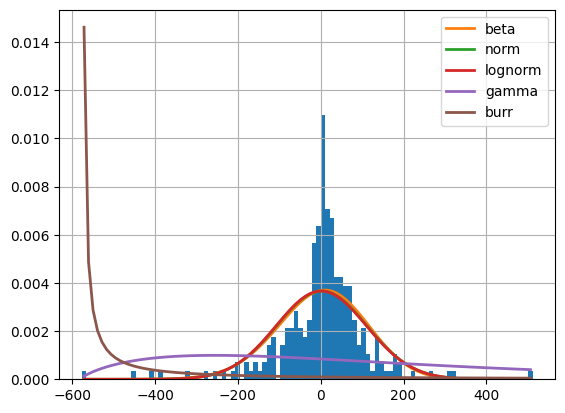

In [18]:
matching_analysis.fit_distributions(get_severity(close_matches, 2), 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  6.51it/s]


         sumsquare_error          aic          bic  kl_div  ks_statistic  \
beta            0.000272  1807.633527 -1262.959142     inf      0.167440   
gamma           0.000272  1803.560079 -1267.490932     inf      0.173149   
norm            0.000274  1796.346072 -1271.531678     inf      0.164724   
lognorm         0.000831  1786.937967 -1155.947274     inf      0.794566   
burr            0.000883  1752.080294 -1145.321754     inf      0.702958   

            ks_pvalue  
beta     6.413351e-03  
gamma    4.311928e-03  
norm     7.710207e-03  
lognorm  3.923730e-68  
burr     3.871696e-50  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  6.93it/s]

{'norm': {'loc': 54.37489471435547, 'scale': 106.96003525491984}}


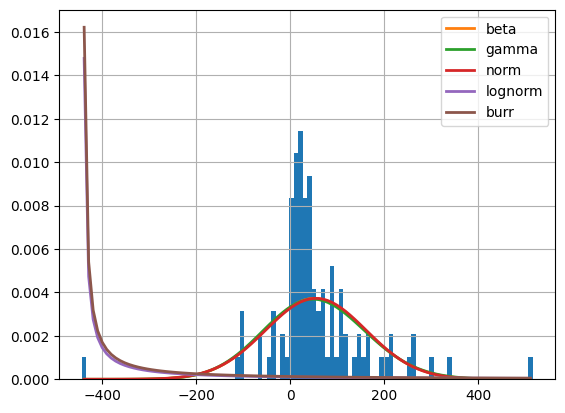

In [19]:
matching_analysis.fit_distributions(get_severity(close_matches, 3), 'agbd')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  8.36it/s]


         sumsquare_error          aic         bic  kl_div  ks_statistic  \
gamma           0.000464  1398.153034 -530.151665     inf      0.065442   
beta            0.000464  1399.943441 -526.294431     inf      0.065120   
norm            0.000534  1441.930547 -527.378116     inf      0.151840   
lognorm         0.001630  1678.831472 -471.094045     inf      0.699866   
burr            0.001739  1618.662475 -464.218613     inf      0.535917   

            ks_pvalue  
gamma    9.799540e-01  
beta     9.809021e-01  
norm     2.064718e-01  
lognorm  1.342721e-23  
burr     3.806278e-13  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]

{'norm': {'loc': 129.4534209839841, 'scale': 124.69034455144067}}


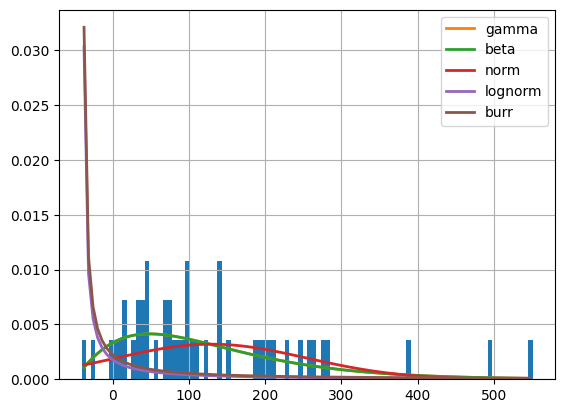

In [20]:
matching_analysis.fit_distributions(get_severity(close_matches, 4), 'agbd')

### Stat tests

In [21]:
matching_analysis.two_sided_tests(get_severity(close_matches, 2), 'agbd')

Shapiro test results ShapiroResult(statistic=0.8795669078826904, pvalue=1.8078090023229687e-13)
Ttest results: TtestResult(statistic=0.36070096269246793, pvalue=0.7186170141675108, df=259)
Wilcoxon test results: WilcoxonResult(statistic=14547.0, pvalue=0.04634751218737901)


In [22]:
matching_analysis.two_sided_tests(get_severity(close_matches, 3), 'agbd')

Shapiro test results ShapiroResult(statistic=0.8515157699584961, pvalue=1.3496331163764808e-08)
Ttest results: TtestResult(statistic=5.05818243289054, pvalue=1.94897952072958e-06, df=99)
Wilcoxon test results: WilcoxonResult(statistic=767.0, pvalue=1.4980428707088134e-09)


In [23]:
matching_analysis.two_sided_tests(get_severity(close_matches, 4), 'agbd')

Shapiro test results ShapiroResult(statistic=0.8745905756950378, pvalue=0.0001224538718815893)
Ttest results: TtestResult(statistic=7.041409835832142, pvalue=7.898174912656163e-09, df=46)
Wilcoxon test results: WilcoxonResult(statistic=19.0, pvalue=4.362732397567015e-12)


## PAI Analysis

In [9]:
matches_l2b = gedi_matching.match_measurements_before_and_after_fire(fire, gedi_burned_l2b, 'pai')

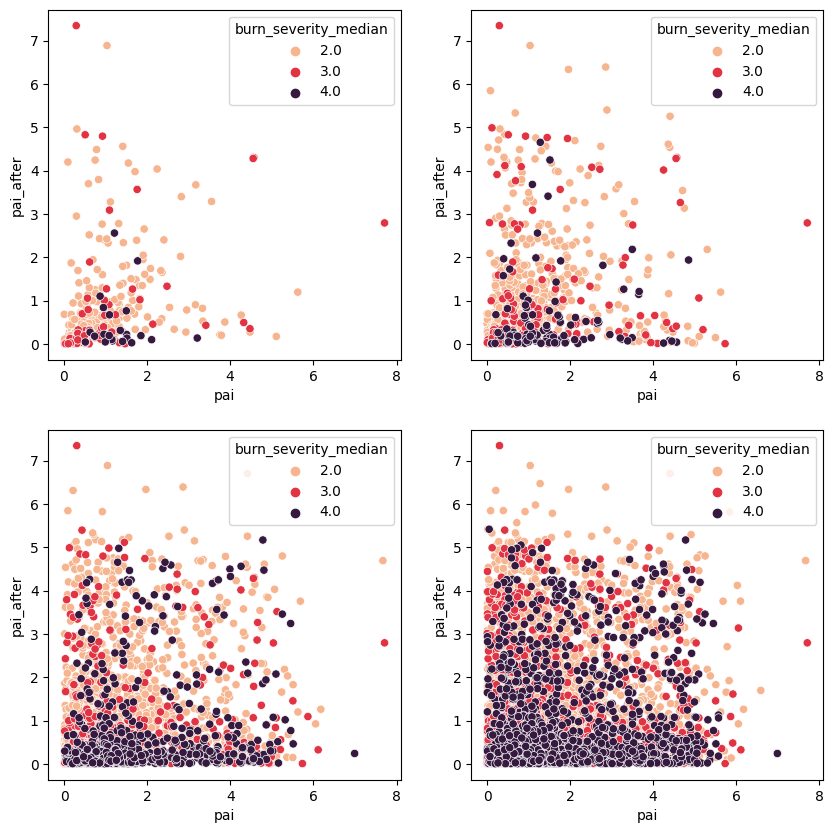

In [25]:
matching_analysis.plot_severity_for_distance(matches_l2b, 'pai')

In [10]:
def l2b_filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1)]

In [2]:
close_matches = l2b_filter_land_cover(matches_l2b[matches_l2b.closest_distance < 20])

NameError: name 'l2b_filter_land_cover' is not defined

In [13]:
close_matches['date_since'] = ((close_matches.match_datetime - fire.cont_date)/np.timedelta64(1, 'M')).astype(int)

Linear regression fit for severity 2.
Best Linear regression coefficient is [0.26137564].         R squared is : 0.04560364966033659.
The error for coeff = 1 is: -0.9753616484134036.
Linear regression fit for severity 3.
Best Linear regression coefficient is [0.14641204].         R squared is : 0.022174614170272.
The error for coeff = 1 is: -0.7681004393928514.
Linear regression fit for severity 4.
Best Linear regression coefficient is [0.01433071].         R squared is : 0.00028793567526719244.
The error for coeff = 1 is: -1.467468289595065.


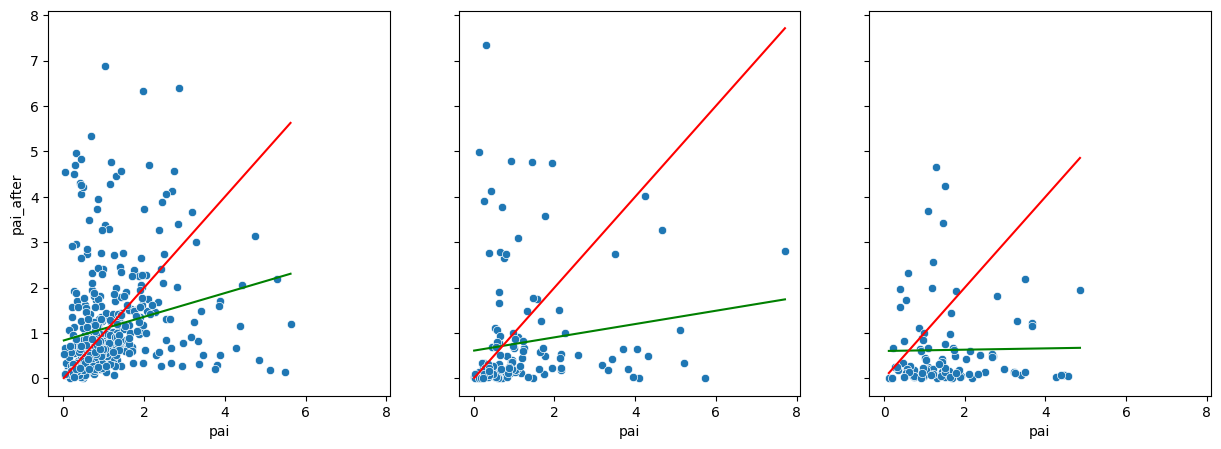

In [29]:
matching_analysis.fit_linear_regression_per_severity(close_matches, 'pai')

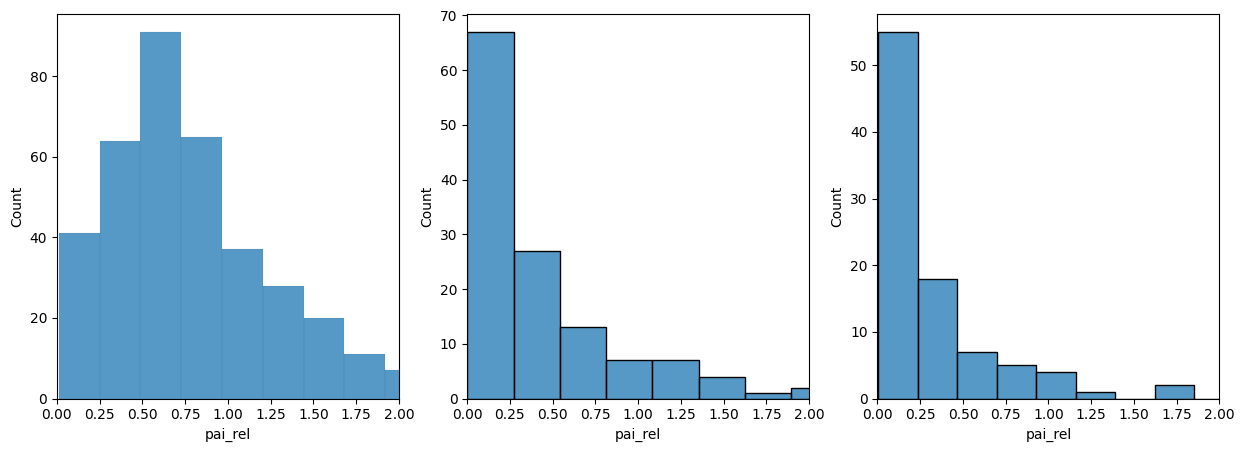

In [30]:
matching_analysis.plot_rel_difference_per_severity(close_matches, 'pai')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  6.69it/s]


         sumsquare_error         aic          bic  kl_div  ks_statistic  \
burr            0.983498  883.221381 -2597.399860     inf      0.117139   
beta            1.653425  855.161758 -2373.500215     inf      0.167455   
lognorm         1.659292  854.974952 -2378.039685     inf      0.171536   
norm            1.659695  850.123485 -2384.001243     inf      0.169556   
gamma           1.727788  836.186869 -2360.605453     inf      0.182837   

            ks_pvalue  
burr     1.309363e-05  
beta     4.939298e-11  
lognorm  1.472625e-11  
norm     2.659050e-11  
gamma    4.413030e-13  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  8.26it/s]

{'norm': {'loc': 0.006490790093967512, 'scale': 1.3161461805770573}}


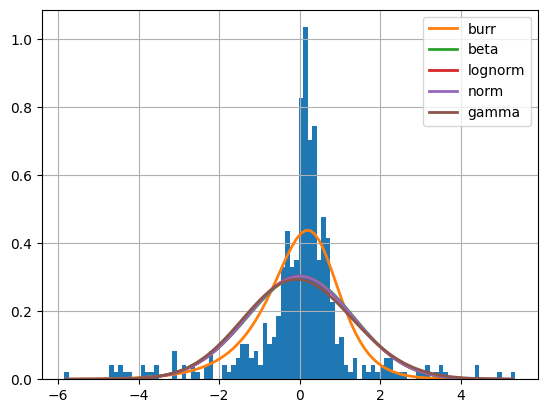

In [31]:
matching_analysis.fit_distributions(get_severity(close_matches, 2), 'pai')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  7.34it/s]


         sumsquare_error         aic         bic  kl_div  ks_statistic  \
lognorm         1.972267  825.217268 -608.214567     inf      0.217914   
beta            1.976767  796.388300 -602.907337     inf      0.208176   
norm            1.978997  813.307995 -612.697348     inf      0.216372   
gamma           2.013210  824.138943 -605.235293     inf      0.229745   
burr            2.413369  842.384123 -573.971041     inf      0.277678   

            ks_pvalue  
lognorm  1.588505e-06  
beta     5.452549e-06  
norm     1.938742e-06  
gamma    3.280500e-07  
burr     2.236977e-10  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

{'norm': {'loc': 0.39843356930827584, 'scale': 1.6794497998020281}}


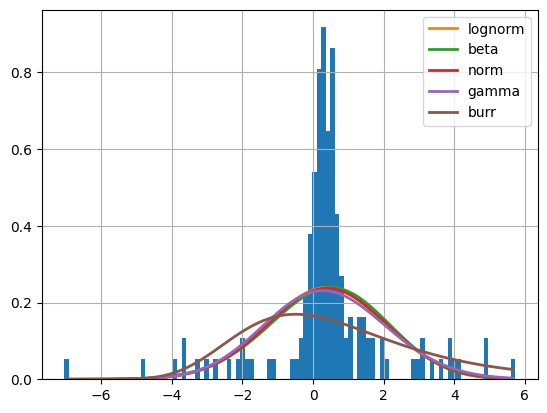

In [32]:
matching_analysis.fit_distributions(get_severity(close_matches, 3), 'pai')

Fitting 5 distributions: 100%|██████████| 5/5 [00:00<00:00,  6.93it/s]


         sumsquare_error         aic         bic  kl_div  ks_statistic  \
burr            1.728868  545.914557 -397.405720     inf      0.075715   
lognorm         1.918654  531.928044 -391.406671     inf      0.106631   
norm            1.922440  527.606099 -395.830544     inf      0.106691   
beta            1.925960  528.697752 -386.394018     inf      0.104304   
gamma           1.931306  530.736940 -390.736247     inf      0.111065   

         ks_pvalue  
burr      0.576109  
lognorm   0.182837  
norm      0.182354  
beta      0.202411  
gamma     0.149668  


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00, 22.43it/s]


{'norm': {'loc': 0.9532405669803922, 'scale': 1.3983012650295326}}


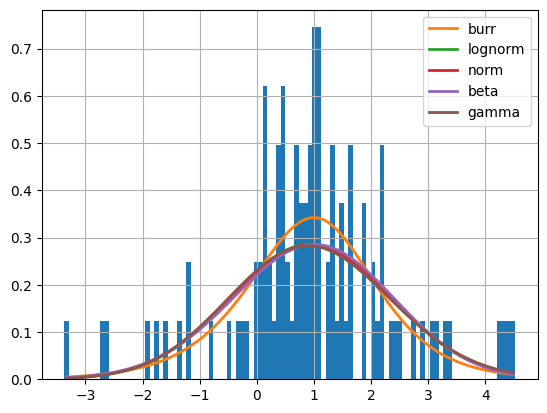

In [33]:
matching_analysis.fit_distributions(get_severity(close_matches, 4), 'pai')

## PAI Z Analysis

In [14]:
from src.data import pai_vertical
importlib.reload(gedi_matching)
importlib.reload(pai_vertical)

<module 'src.data.pai_vertical' from '/home/jk871/fire-regen/src/data/pai_vertical.py'>

In [15]:
matches_paiz = gedi_matching.match_pai_z_before_and_after_fire(fire, gedi_burned_l2b)

In [18]:
close_matches = l2b_filter_land_cover(matches_paiz[matches_paiz.closest_distance < 20])
close_matches['date_since'] = ((close_matches.match_datetime - fire.cont_date)/np.timedelta64(1, 'M')).astype(int)

In [19]:
unpacked = matching_analysis.transform_pai_z_data(close_matches)

(0.0, 13.0)

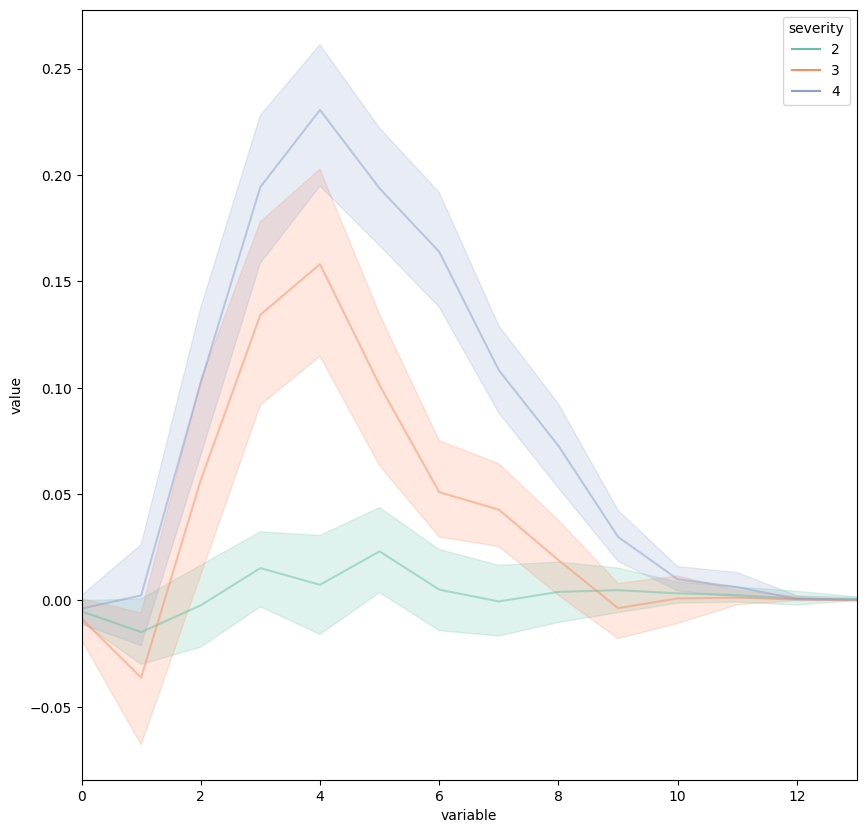

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.lineplot(unpacked, x='variable', y='value', hue='severity', ax=ax, palette='Set2')
ax.set_xlim((0, 13))

(0.0, 13.0)

<Figure size 2000x500 with 0 Axes>

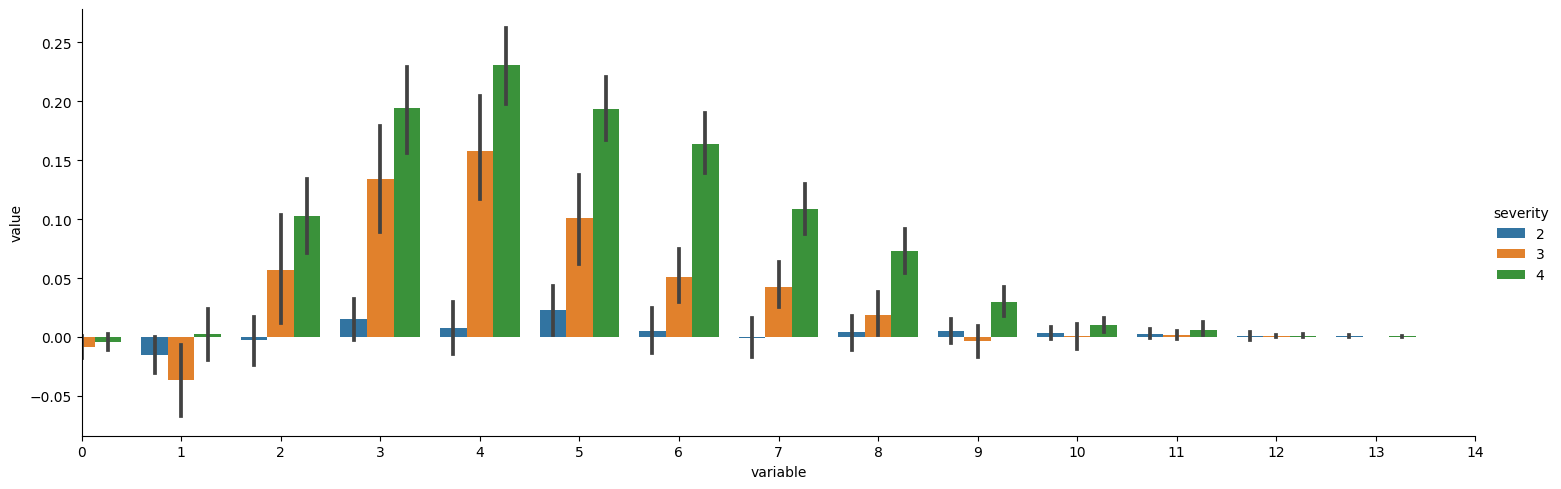

In [22]:
plt.figure(figsize=(20,5))
g = sns.catplot(unpacked, x='variable', y='value', hue='severity', kind='bar', height=5, aspect=3)
g.set(xlim=(0,14))
ax.set_xlim((0, 13))

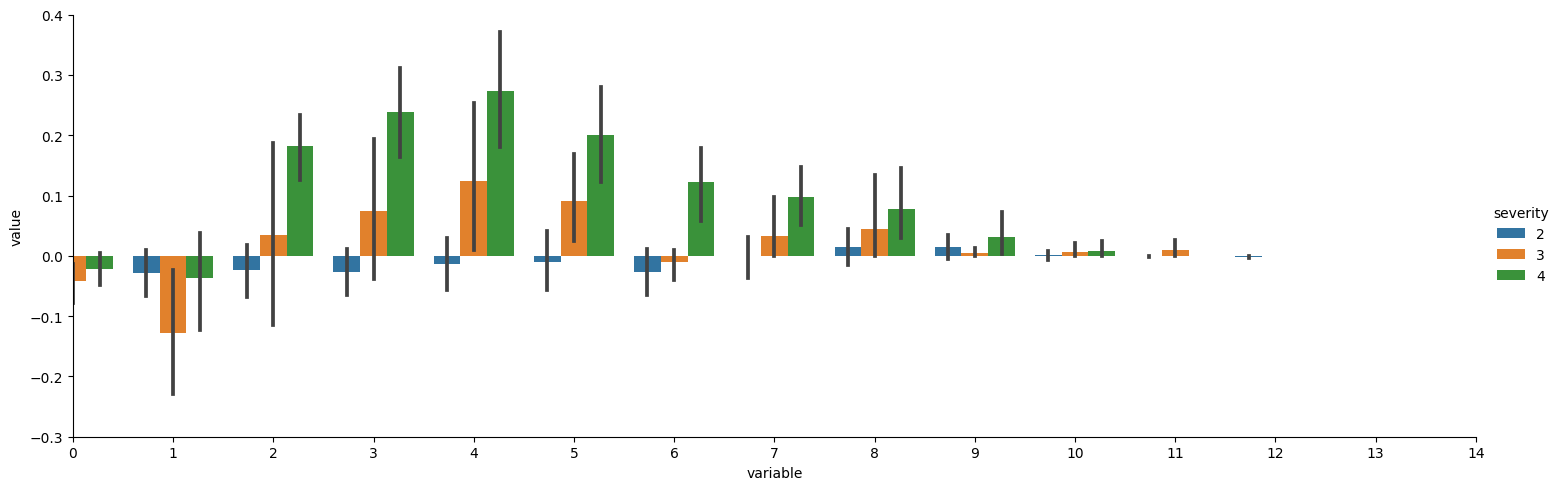

In [31]:
g = sns.catplot(unpacked[unpacked.date_since < 6], x='variable', y='value', hue='severity', kind='bar', height=5, aspect=3)
g.set(xlim=(0,14))
g.set(ylim=(-0.3, 0.4))

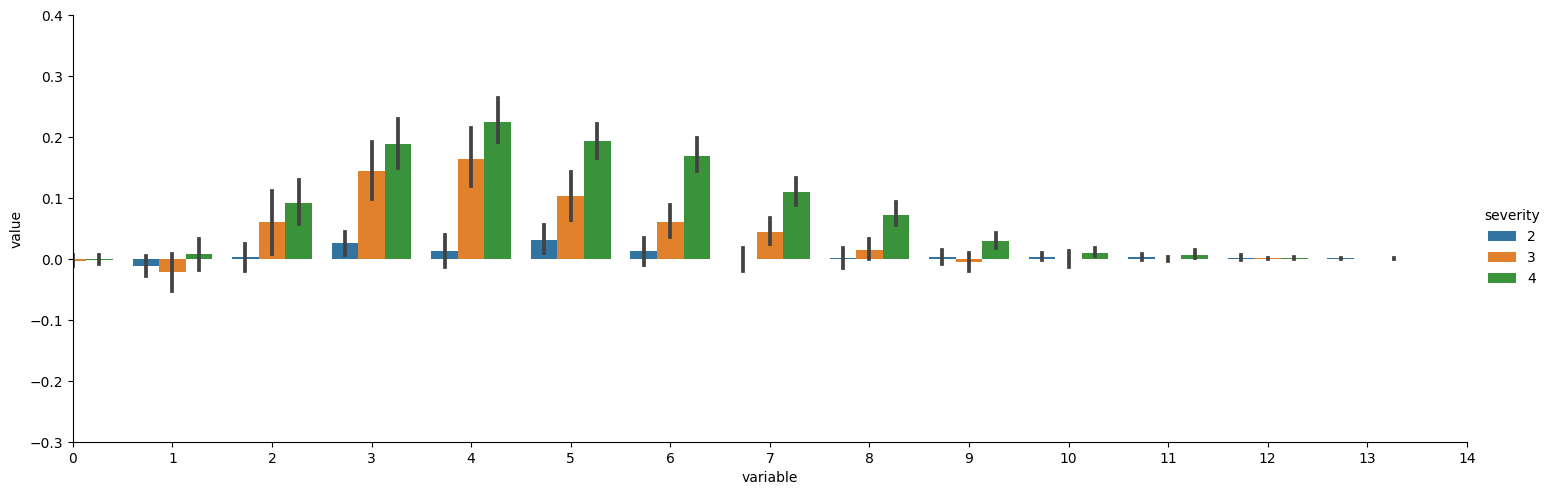

In [33]:
g = sns.catplot(unpacked[unpacked.date_since > 6], x='variable', y='value', hue='severity', kind='bar', height=5, aspect=3)
g.set(xlim=(0,14))
g.set(ylim=(-0.3, 0.4))

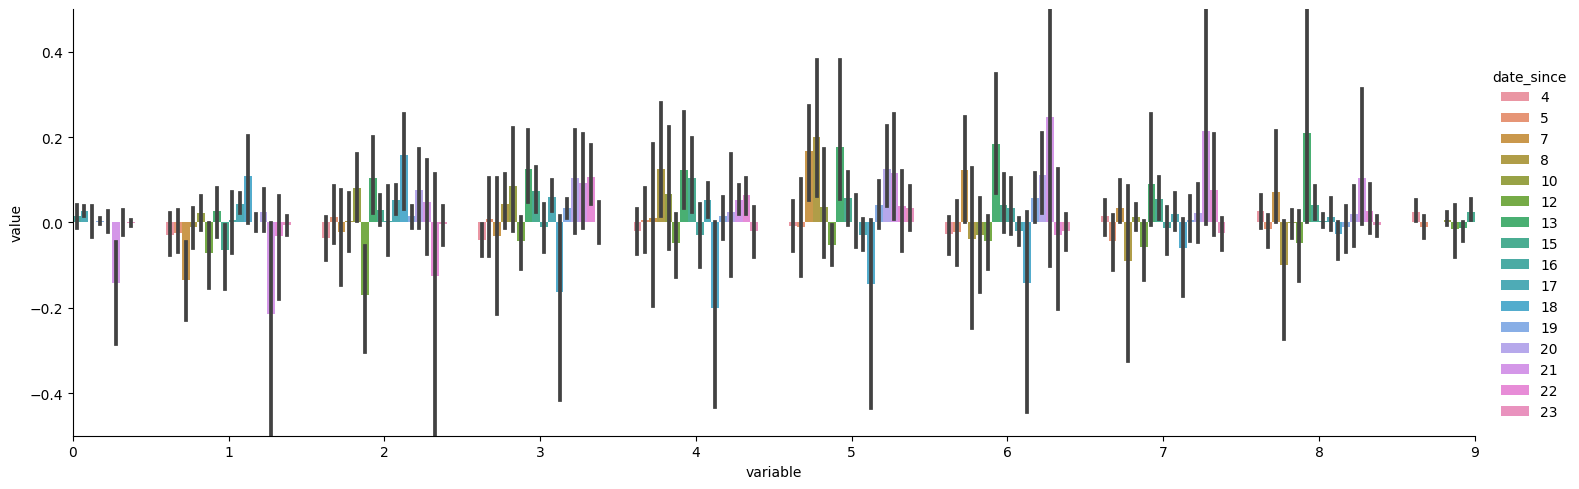

In [34]:
g = sns.catplot(unpacked[unpacked.severity==2], x='variable', y='value', hue='date_since', kind='bar', height=5, aspect=3)
g.set(xlim=(0,9))
g.set(ylim=(-0.5,0.5))

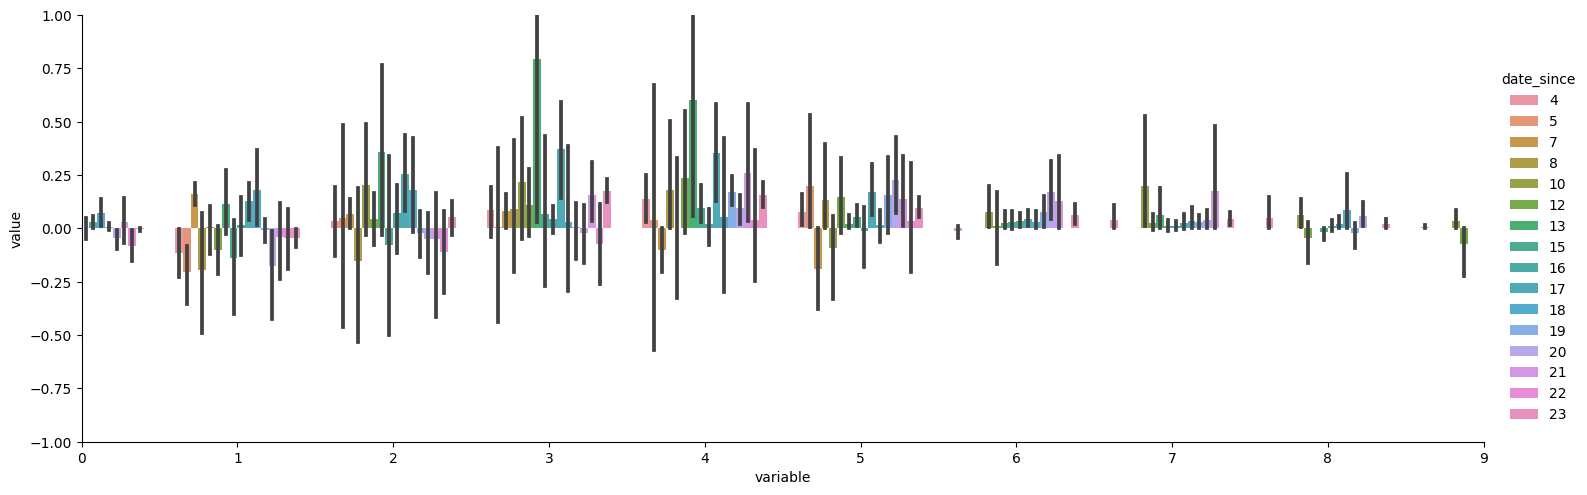

In [36]:
g = sns.catplot(unpacked[unpacked.severity==3], x='variable', y='value', hue='date_since', kind='bar', height=5, aspect=3)
g.set(xlim=(0,9))
g.set(ylim=(-1,1))

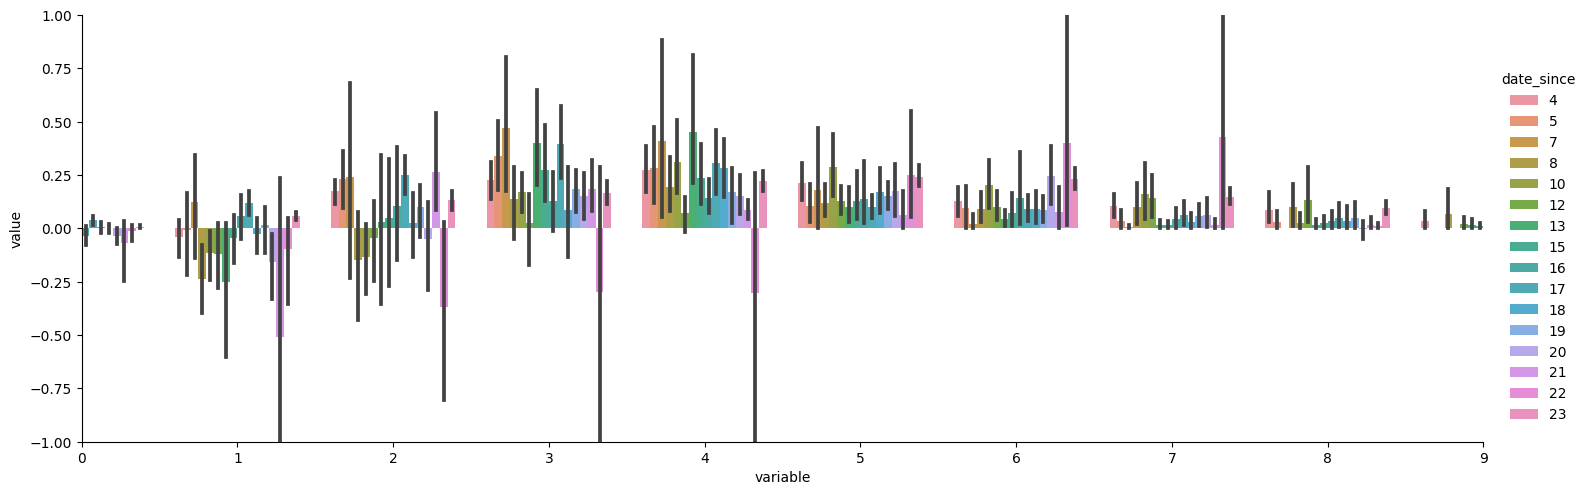

In [37]:
g = sns.catplot(unpacked[unpacked.severity==4], x='variable', y='value', hue='date_since', kind='bar', height=5, aspect=3)
g.set(xlim=(0,9))
g.set(ylim=(-1,1))

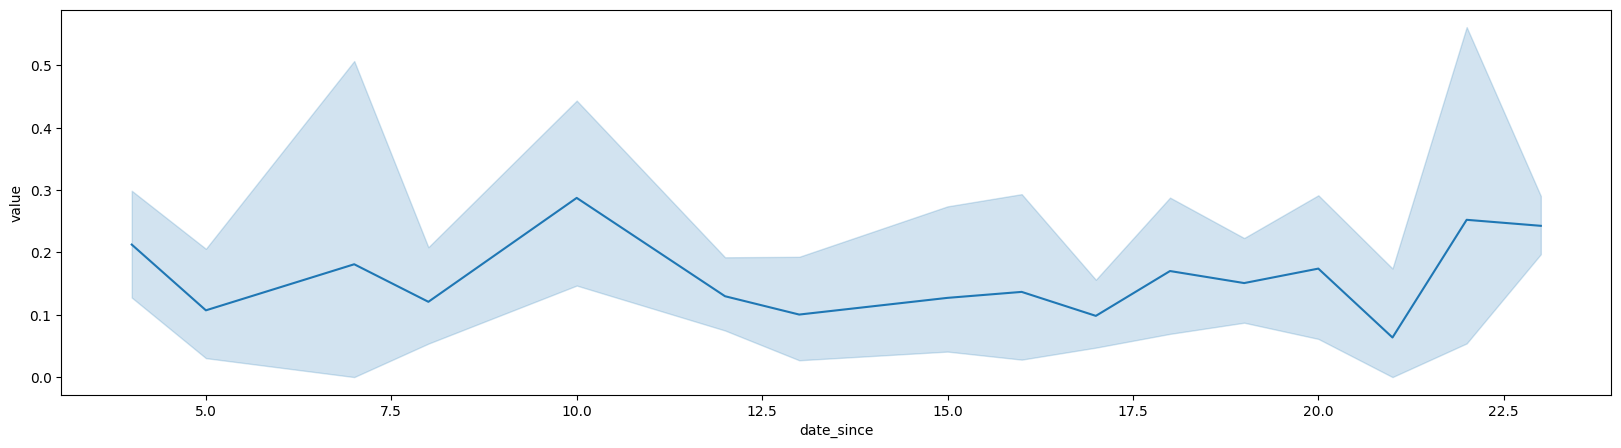

In [48]:
plt.figure(figsize=(20,5))
g = sns.lineplot(unpacked[(unpacked.severity==4) & (unpacked.variable == 5)], x='date_since', y='value')
#g.set(xlim=(0,9))
#g.set(ylim=(-1,1))

[(-1.0, 1.0)]

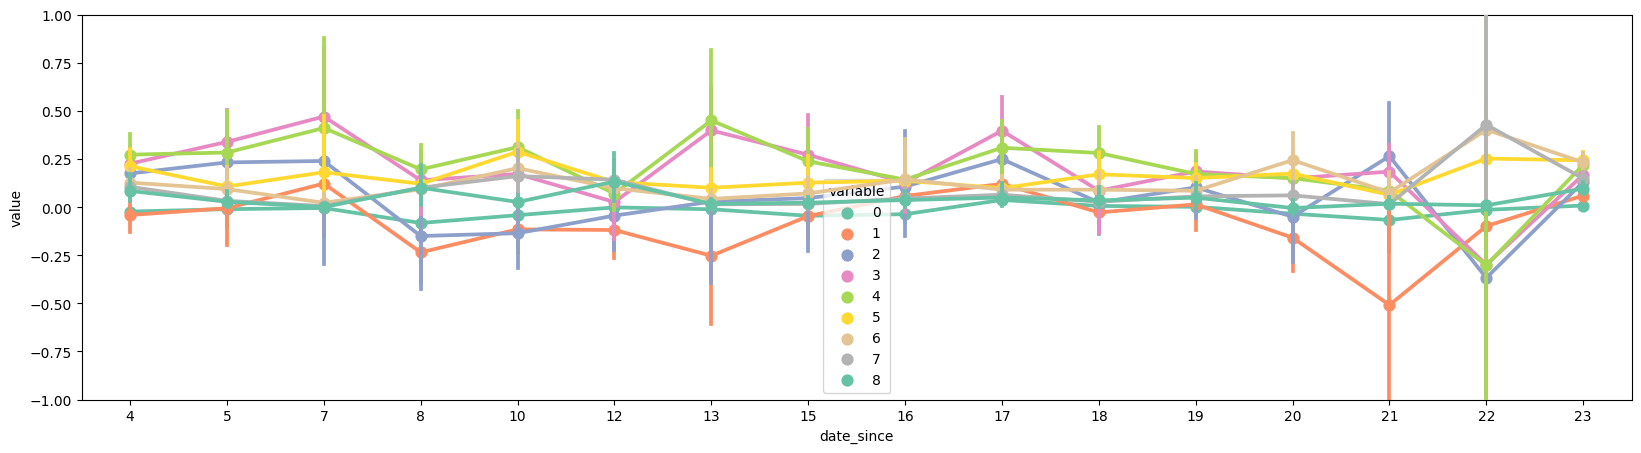

In [49]:
plt.figure(figsize=(20,5))
to_plot = unpacked[unpacked.severity ==4]
g = sns.pointplot(to_plot[to_plot.variable < 9], x='date_since', y='value', hue='variable', palette='Set2')
#g.set(xlim=(0,9))
g.set(ylim=(-1,1))

### Match with EVT raster

In [9]:
from src.data import raster
importlib.reload(gedi_matching)

<module 'src.processing.recent_fires.gedi_matching' from '/home/jk871/fire-regen/src/processing/recent_fires/gedi_matching.py'>

In [135]:
close_matches = filter_land_cover(matches[matches.closest_distance < 20])
close_matches = close_matches[close_matches.date_since > 12]
close_matches.shape[0]

1127

In [133]:
raster.reproject_raster('/maps/fire-regen/data/evt/creek/ca3720111927220200905_20191123_20201202_rdnbr_ba7.tif', f'/maps/fire-regen/data/evt/creek/creek_ba7_4326.tif')

In [134]:
CREEK_DATA_BA7_RASTER = '/maps/fire-regen/data/evt/creek/creek_ba7_4326.tif'
BA7_RASTER_BANDS = {0: 'ba7'}
creek_ba7_raster = raster.RasterSampler(CREEK_DATA_BA7_RASTER, BA7_RASTER_BANDS)

In [136]:
ba7_matches = creek_ba7_raster.sample_2x2(close_matches, 'lon_lowestmode', 'lat_lowestmode')

In [139]:
ba7_matches = gedi_matching.add_agbd_rel_ba7_categories(ba7_matches)

In [141]:
ba7_matches = ba7_matches[ba7_matches.ba7_median != 9]

In [142]:
ba7_matches = ba7_matches.astype({'agbd_rel_ba7': 'int', 'ba7_median': 'int'})

In [143]:
low = ba7_matches[ba7_matches.burn_severity_median == 2]
medium = ba7_matches[ba7_matches.burn_severity_median == 3]
high = ba7_matches[ba7_matches.burn_severity_median == 4]

In [144]:
print(accuracy_score(low.agbd_rel_ba7.values, low.ba7_median.values))
print(accuracy_score(medium.agbd_rel_ba7.values, medium.ba7_median.values))
print(accuracy_score(high.agbd_rel_ba7.values, high.ba7_median.values))

0.25918367346938775
0.1
0.14745308310991956


<Axes: xlabel='agbd_rel', ylabel='Count'>

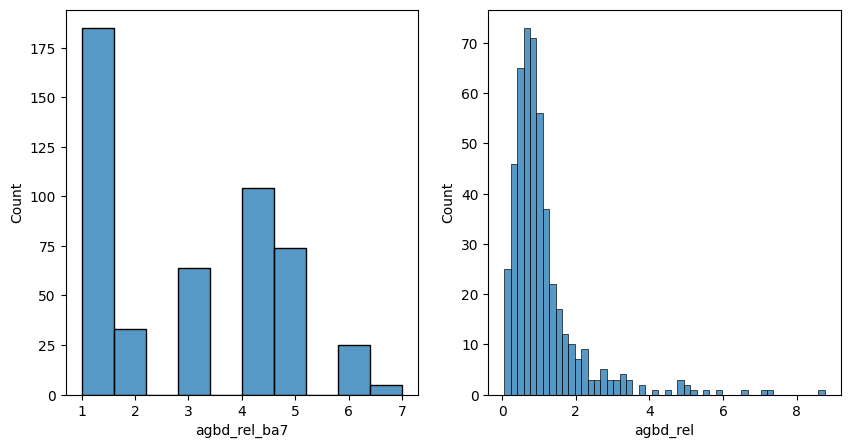

In [145]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(ba7_matches[ba7_matches.burn_severity_median == 2], x='agbd_rel_ba7', ax=ax[0])
sns.histplot(ba7_matches[ba7_matches.burn_severity_median == 2], x='agbd_rel', ax=ax[1])

<Axes: xlabel='agbd_rel', ylabel='Count'>

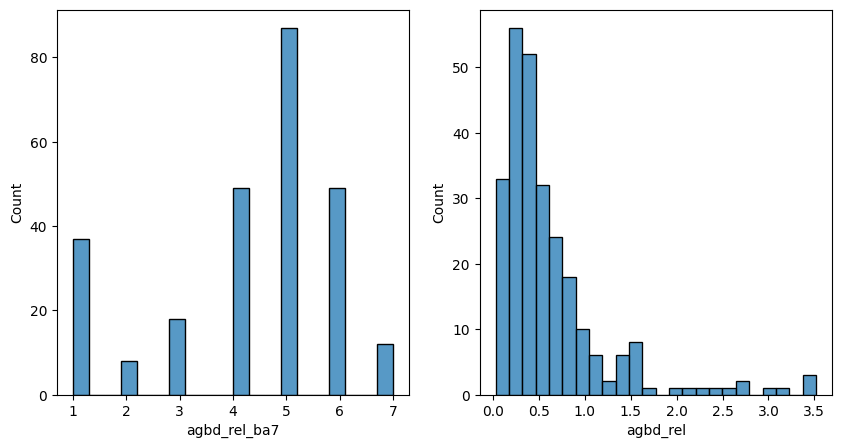

In [147]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(ba7_matches[ba7_matches.burn_severity_median == 3], x='agbd_rel_ba7', ax=ax[0])
sns.histplot(ba7_matches[ba7_matches.burn_severity_median == 3], x='agbd_rel', ax=ax[1])

<Axes: xlabel='agbd_rel', ylabel='Count'>

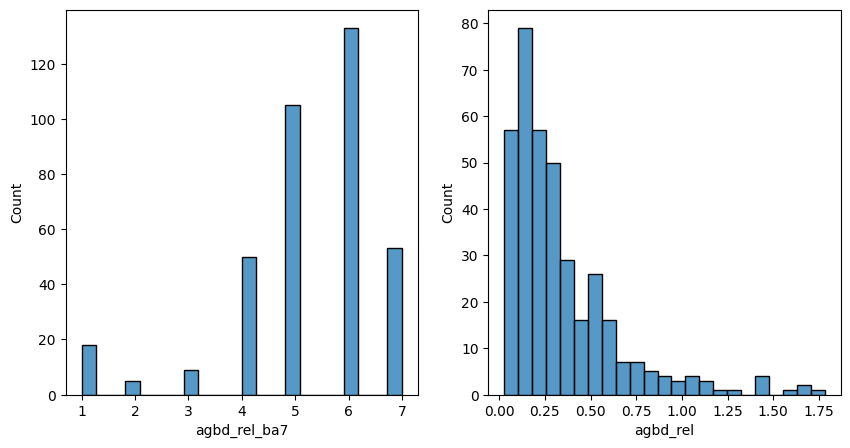

In [148]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(ba7_matches[ba7_matches.burn_severity_median == 4], x='agbd_rel_ba7', ax=ax[0])
sns.histplot(ba7_matches[ba7_matches.burn_severity_median == 4], x='agbd_rel', ax=ax[1])

<Axes: xlabel='ba7_median', ylabel='Count'>

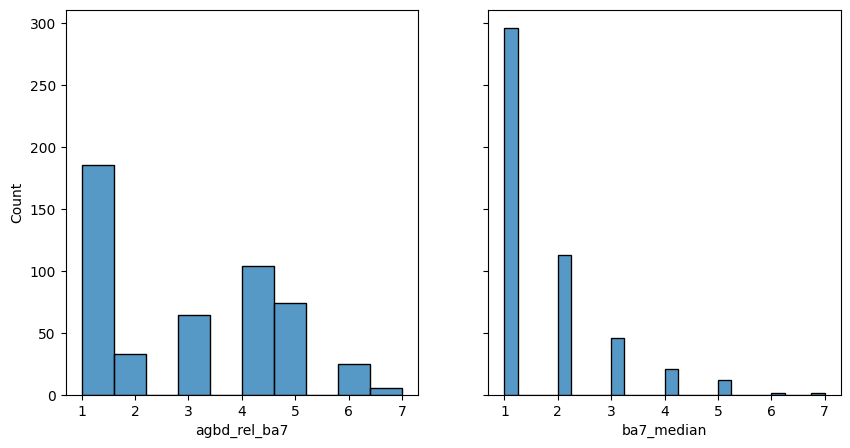

In [146]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)
sns.histplot(ba7_matches[ba7_matches.burn_severity_median == 2], x='agbd_rel_ba7', ax=ax[0])
sns.histplot(ba7_matches[ba7_matches.burn_severity_median == 2], x='ba7_median', ax=ax[1])

<Axes: xlabel='ba7_median', ylabel='Count'>

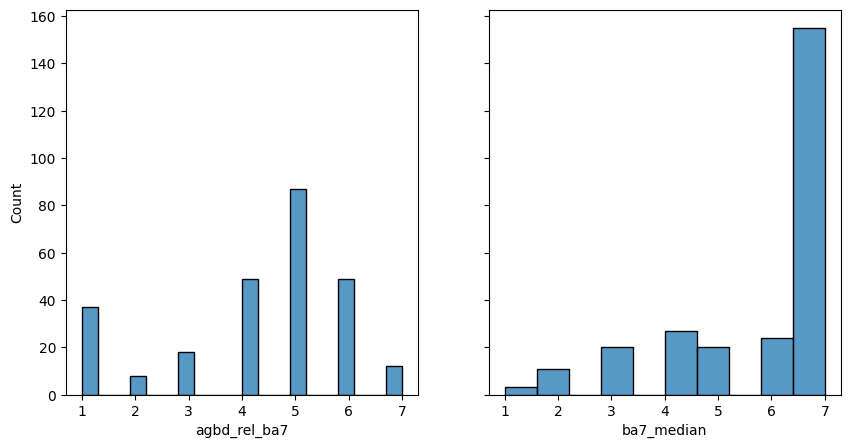

In [149]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)
sns.histplot(ba7_matches[ba7_matches.burn_severity_median == 3], x='agbd_rel_ba7', ax=ax[0])
sns.histplot(ba7_matches[ba7_matches.burn_severity_median == 3], x='ba7_median', ax=ax[1])

<Axes: xlabel='ba7_median', ylabel='Count'>

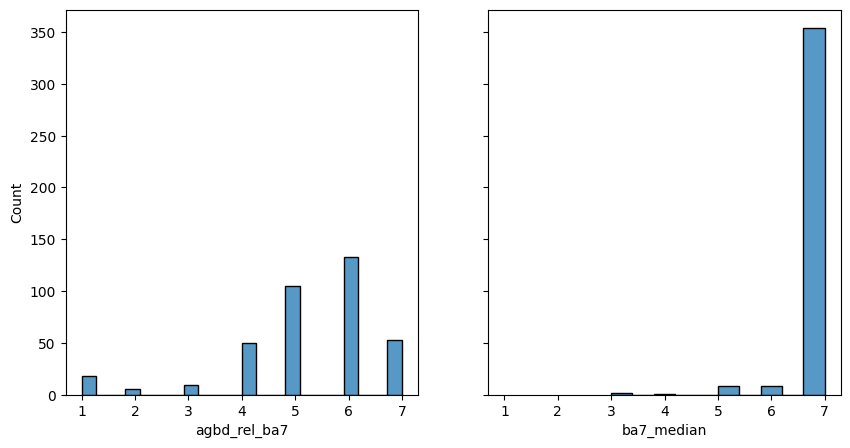

In [150]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)
sns.histplot(ba7_matches[ba7_matches.burn_severity_median == 4], x='agbd_rel_ba7', ax=ax[0])
sns.histplot(ba7_matches[ba7_matches.burn_severity_median == 4], x='ba7_median', ax=ax[1])

### BA4 matches

In [12]:
def filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1) & (df.pft_class == 1)]

In [92]:
raster.reproject_raster('/maps/fire-regen/data/evt/creek/ca3720111927220200905_20191123_20201202_rdnbr_ba4.tif', f'/maps/fire-regen/data/evt/creek/creek_ba4_4326.tif')

In [10]:
CREEK_DATA_BA4_RASTER = '/maps/fire-regen/data/evt/creek/creek_ba4_4326.tif'
BA4_RASTER_BANDS = {0: 'ba4'}
creek_ba4_raster = raster.RasterSampler(CREEK_DATA_BA4_RASTER, BA4_RASTER_BANDS)

In [13]:
close_matches = filter_land_cover(matches[matches.closest_distance < 10])
close_matches = close_matches[close_matches.date_since > 6]
close_matches.shape[0]

351

          Four-category percent basal area (BA) mortality, clipped to fire perimeter. File type: unsigned 8-bit GeoTIFF. Classes:
            0 = outside perimeter
            1 = 0% BA mortality
            2 = 0%  <  BA mortality < 25%
            3 = 25% <= BA mortality < 75%
            4 = BA mortality >= 75%
            9 = unmappable

In [14]:
ba4_matches = creek_ba4_raster.sample_2x2(close_matches, 'lon_lowestmode', 'lat_lowestmode')

In [15]:
ba4_matches = gedi_matching.add_agbd_rel_ba4_categories(ba4_matches)

In [16]:
ba4_matches = ba4_matches[ba4_matches.ba4_median != 9]

In [22]:
ba4_matches = ba4_matches[ba4_matches.agbd_rel < 2]
ba4_matches.shape[0]

321

In [17]:
ba4_matches

,shot_number,absolute_time,lon_lowestmode,lat_lowestmode,agbd,agbd_pi_lower,agbd_pi_upper,agbd_se,l2_quality_flag,l4_quality_flag,...,agbd_rel,start_offset,end_offset,cont_date,date_since,ba4_2x2,ba4_mean,ba4_std,ba4_median,agbd_rel_ba4
11996492,88360000200086605,2020-07-04 09:05:10.088068+00:00,-119.229011,37.152945,451.782532,248.594269,715.213684,11.122843,1,1,...,1.256583,0,None,2020-12-24 00:00:00+00:00,10,"[1, 2, 1, 1]",1.25,0.433013,1.0,1
12157975,21830300200228543,2019-05-02 10:57:50.269018+00:00,-119.411643,37.181964,47.447853,1.973796,153.055542,11.102661,1,1,...,0.612710,0,None,2020-12-24 00:00:00+00:00,18,"[2, 2, 3, 3]",2.50,0.500000,2.5,3
12170633,35270000200123541,2019-07-28 00:37:14.074257+00:00,-119.422682,37.236453,363.807922,184.597275,603.234985,11.117934,1,1,...,0.253081,0,None,2020-12-24 00:00:00+00:00,18,"[1, 1, 2, 1]",1.25,0.433013,1.0,3
12272020,88970600200440780,2020-07-08 07:31:32.407643+00:00,-119.187062,37.229996,45.070934,1.492389,148.970444,11.137244,1,1,...,3.893160,0,None,2020-12-24 00:00:00+00:00,12,"[2, 2, 2, 2]",2.00,0.000000,2.0,1
12334669,88970300200080572,2020-07-08 07:31:31.849824+00:00,-119.211399,37.229324,271.485657,120.515640,482.930573,11.165677,1,1,...,0.908891,0,None,2020-12-24 00:00:00+00:00,12,"[1, 1, 1, 1]",1.00,0.000000,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20973479,87750500200119499,2020-06-30 10:39:47.932352+00:00,-119.190007,37.410467,298.070221,138.483170,518.087463,11.157408,1,1,...,0.049680,0,None,2020-12-24 00:00:00+00:00,23,"[4, 4, 4, 4]",4.00,0.000000,4.0,4
21317782,87750000200123428,2020-06-30 10:39:48.804249+00:00,-119.157721,37.462618,118.656349,29.237324,268.263245,11.112677,1,1,...,0.151401,0,None,2020-12-24 00:00:00+00:00,23,"[4, 4, 4, 4]",4.00,0.000000,4.0,4
21317785,87750000200123431,2020-06-30 10:39:48.829041+00:00,-119.156246,37.463632,227.323090,92.007866,422.812408,11.110123,1,1,...,0.123330,0,None,2020-12-24 00:00:00+00:00,23,"[4, 4, 4, 4]",4.00,0.000000,4.0,4
21339019,87750500200119593,2020-06-30 10:39:48.709213+00:00,-119.144008,37.441979,154.424652,48.137676,320.961975,11.124209,1,1,...,0.099172,0,None,2020-12-24 00:00:00+00:00,23,"[4, 4, 4, 4]",4.00,0.000000,4.0,4


In [101]:
from sklearn.metrics import *

In [18]:
ba4_matches = ba4_matches.astype({'agbd_rel_ba4': 'int', 'ba4_median': 'int'})

In [23]:
low = ba4_matches[ba4_matches.burn_severity_median == 2]
medium = ba4_matches[ba4_matches.burn_severity_median == 3]
high = ba4_matches[ba4_matches.burn_severity_median == 4]

In [24]:
print(accuracy_score(low.agbd_rel_ba4.values, low.ba4_median.values))
print(accuracy_score(medium.agbd_rel_ba4.values, medium.ba4_median.values))
print(accuracy_score(high.agbd_rel_ba4.values, high.ba4_median.values))

0.2864583333333333
0.25287356321839083
0.38095238095238093


In [127]:
print(r2_score(low.agbd_rel_ba4.values, low.ba4_median.values))
print(r2_score(medium.agbd_rel_ba4.values, medium.ba4_median.values))
print(r2_score(high.agbd_rel_ba4.values, high.ba4_median.values))

-0.8501160946032045
-1.0990617499454505
-0.659076663452266


In [128]:
print(mean_squared_error(low.agbd_rel_ba4.values, low.ba4_median.values))
print(mean_squared_error(medium.agbd_rel_ba4.values, medium.ba4_median.values))
print(mean_squared_error(high.agbd_rel_ba4.values, high.ba4_median.values))

1.8020408163265307
1.85
0.9892761394101877


<Axes: xlabel='agbd_rel_ba4', ylabel='ba4_median'>

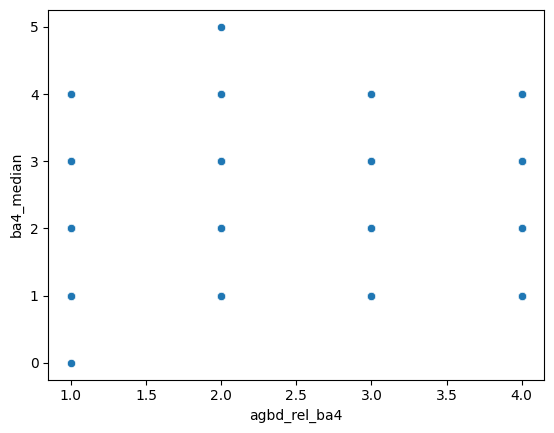

In [106]:
sns.scatterplot(ba4_matches, x='agbd_rel_ba4', y='ba4_median')

<Axes: xlabel='agbd_rel', ylabel='Count'>

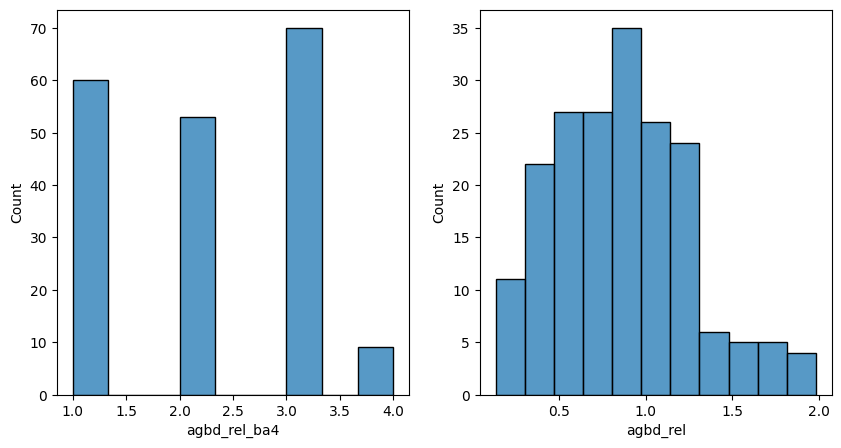

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(ba4_matches[ba4_matches.burn_severity_median == 2], x='agbd_rel_ba4', ax=ax[0])
sns.histplot(ba4_matches[ba4_matches.burn_severity_median == 2], x='agbd_rel', ax=ax[1])

<Axes: xlabel='agbd_rel', ylabel='Count'>

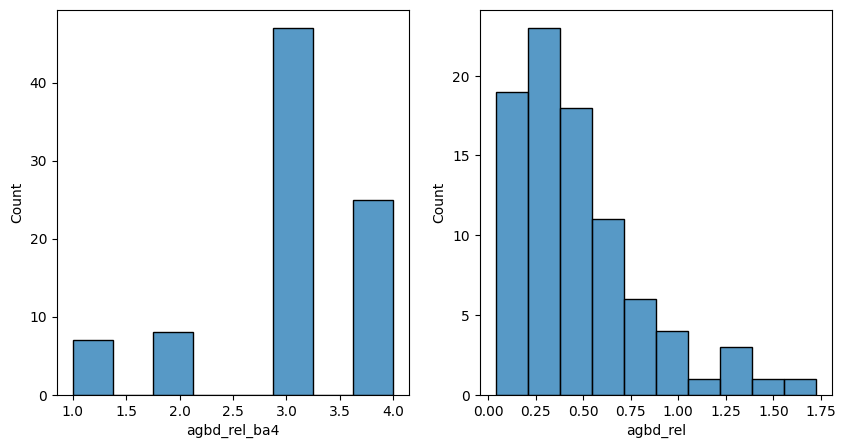

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(ba4_matches[ba4_matches.burn_severity_median == 3], x='agbd_rel_ba4', ax=ax[0])
sns.histplot(ba4_matches[ba4_matches.burn_severity_median == 3], x='agbd_rel', ax=ax[1])

<Axes: xlabel='agbd_rel', ylabel='Count'>

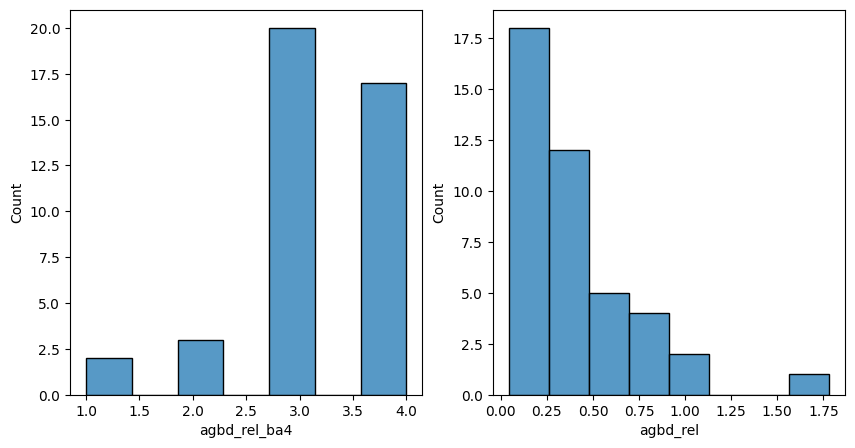

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(ba4_matches[ba4_matches.burn_severity_median == 4], x='agbd_rel_ba4', ax=ax[0])
sns.histplot(ba4_matches[ba4_matches.burn_severity_median == 4], x='agbd_rel', ax=ax[1])

<Axes: xlabel='ba4_median', ylabel='Count'>

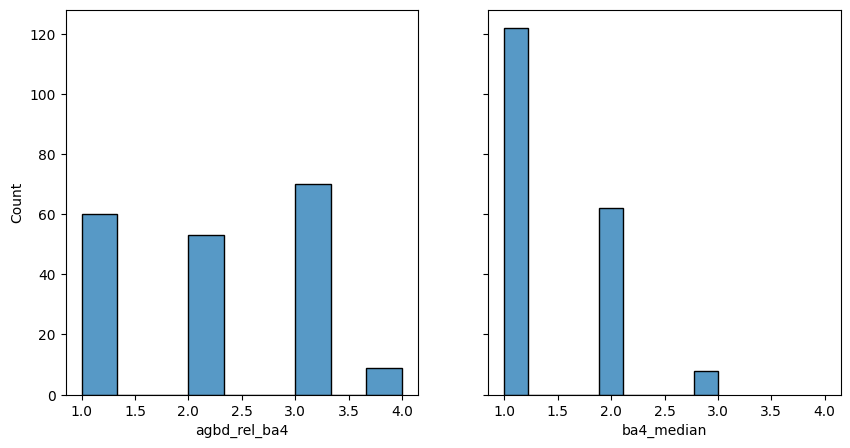

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)
sns.histplot(ba4_matches[ba4_matches.burn_severity_median == 2], x='agbd_rel_ba4', ax=ax[0])
sns.histplot(ba4_matches[ba4_matches.burn_severity_median == 2], x='ba4_median', ax=ax[1])

<Axes: xlabel='ba4_median', ylabel='Count'>

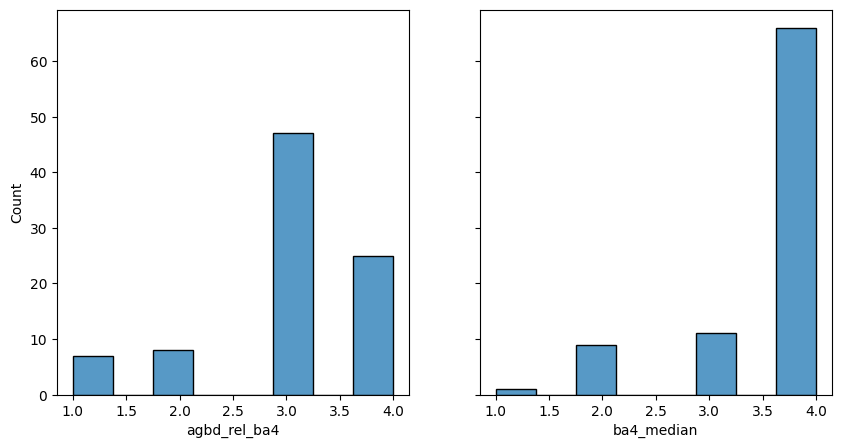

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)
sns.histplot(ba4_matches[ba4_matches.burn_severity_median == 3], x='agbd_rel_ba4', ax=ax[0])
sns.histplot(ba4_matches[ba4_matches.burn_severity_median == 3], x='ba4_median', ax=ax[1])

In [34]:
ba4_matches[(ba4_matches.agbd_rel_ba4 == 4) & (ba4_matches.ba4_median == 2)]

,shot_number,absolute_time,lon_lowestmode,lat_lowestmode,agbd,agbd_pi_lower,agbd_pi_upper,agbd_se,l2_quality_flag,l4_quality_flag,...,agbd_rel,start_offset,end_offset,cont_date,date_since,ba4_2x2,ba4_mean,ba4_std,ba4_median,agbd_rel_ba4
20956278,87750300200119574,2020-06-30 10:39:48.345597+00:00,-119.149621,37.446655,219.358139,86.897087,412.074799,11.125196,1,1,...,0.152866,0,None,2020-12-24 00:00:00+00:00,23,"[2, 2, 2, 2]",2.00,0.000000,2,4
12803240,22901100200079703,2019-05-09 08:15:06.852229+00:00,-119.469300,37.369903,341.369629,168.742386,574.191528,11.113924,1,1,...,0.230576,0,None,2020-12-24 00:00:00+00:00,19,"[2, 1, 3, 2]",2.00,0.707107,2,4
21001469,87751100200119419,2020-06-30 10:39:48.486085+00:00,-119.158054,37.409293,116.392921,27.818285,265.781494,11.228265,1,1,...,0.199300,0,None,2020-12-24 00:00:00+00:00,23,"[3, 2, 2, 2]",2.25,0.433013,2,4
21053477,87140600200403694,2020-06-26 12:14:33.954147+00:00,-119.171964,37.502698,305.396393,143.746109,527.242920,11.114229,1,1,...,0.165621,0,None,2020-12-24 00:00:00+00:00,10,"[2, 2, 2, 3]",2.25,0.433013,2,4


<Axes: xlabel='ba4_median', ylabel='Count'>

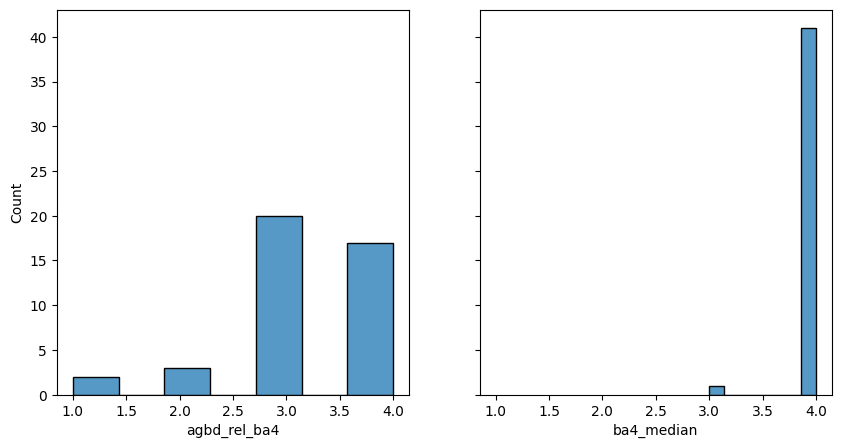

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)
sns.histplot(ba4_matches[ba4_matches.burn_severity_median == 4], x='agbd_rel_ba4', ax=ax[0])
sns.histplot(ba4_matches[ba4_matches.burn_severity_median == 4], x='ba4_median', ax=ax[1])

In [ ]:
ba4_matches[ba4_matches.agbd_rel_ba4]

<Axes: xlabel='burn_severity_median', ylabel='ba4_mean'>

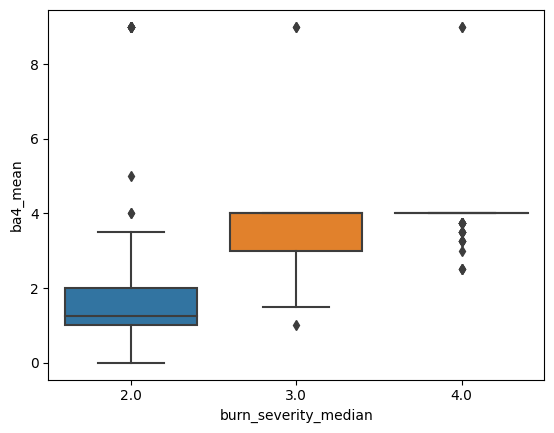

In [45]:
sns.boxplot(ba4_matches, x="burn_severity_median", y="ba4_mean")

In [44]:
ba4_matches

,shot_number,absolute_time,lon_lowestmode,lat_lowestmode,agbd,agbd_pi_lower,agbd_pi_upper,agbd_se,l2_quality_flag,l4_quality_flag,...,match_datetime,agbd_after,agbd_diff,agbd_rel,start_offset,end_offset,ba4_2x2,ba4_mean,ba4_std,ba4_median
11852222,42640200300290719,2019-09-13 12:53:30.052482+00:00,-119.258215,37.187048,697.930786,437.760498,1018.505432,11.152656,1,1,...,2021-05-15 04:34:56.787113+00:00,539.852966,158.077820,0.773505,0,None,"[1, 2, 1, 1]",1.25,0.433013,1.0
11890025,42641100300289377,2019-09-13 12:53:30.924389+00:00,-119.263927,37.149189,173.976425,59.397606,348.682404,11.101473,1,1,...,2021-05-11 06:07:53.929856+00:00,155.747086,18.229340,0.895219,0,None,"[1, 1, 1, 1]",1.00,0.000000,1.0
11898647,42641100300289460,2019-09-13 12:53:31.626884+00:00,-119.222612,37.120599,125.560822,32.466618,279.318878,11.200562,1,1,...,2021-05-07 07:40:48.708448+00:00,152.420792,-26.859970,1.213920,0,None,"[1, 1, 1, 1]",1.00,0.000000,1.0
11969093,43360600200402919,2019-09-18 03:56:51.278321+00:00,-119.198684,37.179487,62.567810,5.858725,179.546143,11.127700,1,1,...,2021-11-13 11:37:04.415318+00:00,126.623932,-64.056122,2.023787,0,None,"[9, 9, 9, 9]",9.00,0.000000,9.0
11996492,88360000200086605,2020-07-04 09:05:10.088068+00:00,-119.229011,37.152945,451.782532,248.594269,715.213684,11.122843,1,1,...,2021-11-13 11:37:04.655023+00:00,567.702454,-115.919922,1.256583,0,None,"[1, 2, 1, 1]",1.25,0.433013,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22792077,88970000200084862,2020-07-08 07:31:30.581189+00:00,-119.320995,37.175265,459.156158,254.067444,724.490723,11.123384,1,1,...,2022-06-26 11:27:48.791454+00:00,56.028934,403.127224,0.122026,0,None,"[4, 4, 4, 4]",4.00,0.000000,4.0
22792080,88970000200084874,2020-07-08 07:31:30.680380+00:00,-119.315153,37.179345,53.661945,3.392779,164.068237,11.103308,1,1,...,2022-06-26 11:27:48.890622+00:00,32.147575,21.514370,0.599076,0,None,"[4, 4, 4, 4]",4.00,0.000000,4.0
22793237,88970300200080341,2020-07-08 07:31:29.899409+00:00,-119.325792,37.150273,98.908409,19.912167,238.030441,11.101218,1,1,...,2021-09-06 14:27:47.905791+00:00,31.415039,67.493370,0.317617,0,None,"[4, 4, 4, 4]",4.00,0.000000,4.0
22793241,88970500200080282,2020-07-08 07:31:30.229968+00:00,-119.322231,37.144113,240.941956,100.646477,441.518402,11.129862,1,1,...,2022-07-22 08:20:43.186767+00:00,17.805578,223.136377,0.073900,0,None,"[4, 4, 4, 4]",4.00,0.000000,4.0


<Axes: >

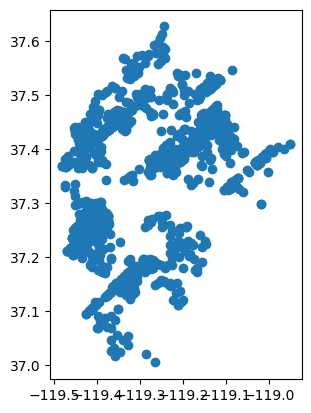

In [30]:
close_matches.plot()

<Axes: >

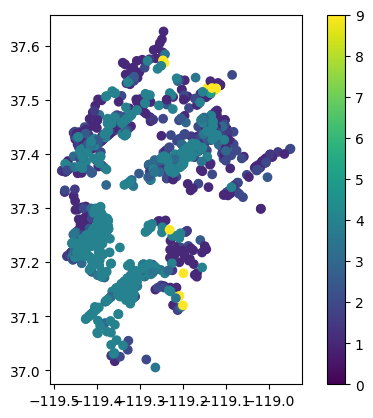

In [37]:
ba4_matches.plot(column='ba4_median', legend=True)

### Canopy cover loss matching

In [160]:
def l2b_filter_land_cover(df):
    return df[(df.land_cover_std == 0) & (df.land_cover_mean == 1)]

In [157]:
importlib.reload(gedi_matching)

<module 'src.processing.recent_fires.gedi_matching' from '/home/jk871/fire-regen/src/processing/recent_fires/gedi_matching.py'>

In [161]:
matches_l2b = gedi_matching.match_measurements_before_and_after_fire(fire, gedi_burned_l2b, 'cover')

In [195]:
close_matches_l2b = l2b_filter_land_cover(matches_l2b[matches_l2b.closest_distance < 20])

In [153]:
raster.reproject_raster('/maps/fire-regen/data/evt/creek/ca3720111927220200905_20191123_20201202_rdnbr_cc5.tif', f'/maps/fire-regen/data/evt/creek/creek_cc5_4326.tif')

In [154]:
CREEK_DATA_CC5_RASTER = '/maps/fire-regen/data/evt/creek/creek_cc5_4326.tif'
CC5_RASTER_BANDS = {0: 'cc5'}
creek_cc5_raster = raster.RasterSampler(CREEK_DATA_CC5_RASTER, CC5_RASTER_BANDS)

In [180]:
cc5_matches = creek_cc5_raster.sample_2x2(close_matches_l2b, 'lon_lowestmode', 'lat_lowestmode')

In [1]:
cc5_matches

NameError: name 'cc5_matches' is not defined

In [181]:
cc5_matches

,shot_number,absolute_time,lon_lowestmode,lat_lowestmode,fhd_normal,pai,pai_z,pavd_z,rh100,cover,...,cover_diff,cover_rel,start_offset,end_offset,cont_date,date_since,cc5_2x2,cc5_mean,cc5_std,cc5_median
235199,22901100200079865,2019-05-09 08:15:08.199316+00:00,-119.389355,37.424742,3.016174,1.705056,"[1.7050562, 1.0783417, 0.58044803, 0.38577446,...","[0.12534288, 0.11246081, 0.06925673, 0.0329100...",3249,0.573488,...,0.281104,0.509834,0,None,2020-12-24 00:00:00+00:00,19,"[1, 1, 1, 1]",1.00,0.000000,1.0
235200,22901100200079871,2019-05-09 08:15:08.248900+00:00,-119.386417,37.426755,3.226404,0.503562,"[0.5035624, 0.40696147, 0.26319423, 0.15600963...","[0.019320188, 0.024036815, 0.025095183, 0.0187...",2770,0.222563,...,0.074769,0.664055,0,None,2020-12-24 00:00:00+00:00,19,"[1, 1, 1, 1]",1.00,0.000000,1.0
235203,22901100200079879,2019-05-09 08:15:08.315012+00:00,-119.382509,37.429432,2.540104,0.745412,"[0.7454115, 0.56732, 0.16702147, -0.0, -0.0, -...","[0.0356183, 0.057839002, 0.056732, 0.016702147...",1489,0.311086,...,0.004590,0.985247,0,None,2020-12-24 00:00:00+00:00,19,"[2, 2, 3, 4]",2.75,0.829156,2.5
235205,22901100200079897,2019-05-09 08:15:08.463764+00:00,-119.373684,37.435476,3.250204,1.039573,"[1.0380596, 0.8389016, 0.6044246, 0.4197897, 0...","[0.03983159, 0.043363493, 0.04191119, 0.028918...",4263,0.405272,...,-0.560354,2.382662,0,None,2020-12-24 00:00:00+00:00,19,"[2, 2, 1, 2]",1.75,0.433013,2.0
263317,42640300300289378,2019-09-13 12:53:27.378912+00:00,-119.416937,37.289747,3.016271,0.938805,"[0.938805, 0.6560121, 0.34693518, 0.20568947, ...","[0.05655858, 0.05918698, 0.045032263, 0.026124...",2520,0.374585,...,0.027192,0.927408,0,None,2020-12-24 00:00:00+00:00,4,"[1, 1, 1, 1]",1.00,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25541077,88970600200440486,2020-07-08 07:31:29.936596+00:00,-119.332092,37.129747,3.219730,0.873678,"[0.871226, 0.5900358, 0.38659826, 0.25623223, ...","[0.056238048, 0.04846278, 0.033380356, 0.02315...",3012,0.353672,...,-0.070651,1.199764,0,None,2020-12-24 00:00:00+00:00,8,"[5, 5, 5, 5]",5.00,0.000000,5.0
25740529,88970100200080995,2020-07-08 07:31:35.833294+00:00,-119.004419,37.386214,2.839864,1.171817,"[1.1703671, 0.5607412, 0.35308236, 0.2523752, ...","[0.12192518, 0.08172847, 0.030836603, 0.026127...",2351,0.442965,...,0.407945,0.079060,0,None,2020-12-24 00:00:00+00:00,4,"[5, 5, 5, 5]",5.00,0.000000,5.0
25816242,42641100300289291,2019-09-13 12:53:30.213629+00:00,-119.305689,37.178103,3.016773,1.359591,"[1.3595912, 0.95931596, 0.46537593, 0.19469401...","[0.08005506, 0.08942153, 0.076462194, 0.037554...",2835,0.493233,...,0.347877,0.294699,0,None,2020-12-24 00:00:00+00:00,4,"[5, 5, 5, 5]",5.00,0.000000,5.0
25843407,88360500200081608,2020-07-04 09:05:07.968241+00:00,-119.333332,37.049894,2.873808,0.954077,"[0.95383483, 0.6770659, 0.36300007, 0.07243865...","[0.055353787, 0.059083477, 0.060462724, 0.0363...",1913,0.379044,...,0.035691,0.905839,0,None,2020-12-24 00:00:00+00:00,4,"[5, 5, 5, 5]",5.00,0.000000,5.0


In [182]:
cc5_matches = gedi_matching.add_cover_rel_cc5_categories(cc5_matches)

In [183]:
cc5_matches = cc5_matches[cc5_matches.cc5_median != 9]

In [184]:
cc5_matches = cc5_matches.astype({'cover_rel_cc5': 'int', 'cc5_median': 'int'})

In [185]:
low = cc5_matches[cc5_matches.burn_severity_median == 2]
medium = cc5_matches[cc5_matches.burn_severity_median == 3]
high = cc5_matches[cc5_matches.burn_severity_median == 4]

In [186]:
print(accuracy_score(low.cover_rel_cc5.values, low.cc5_median.values))
print(accuracy_score(medium.cover_rel_cc5.values, medium.cc5_median.values))
print(accuracy_score(high.cover_rel_cc5.values, high.cc5_median.values))

0.3032258064516129
0.3333333333333333
0.5454545454545454


In [187]:
print(r2_score(low.cover_rel_cc5.values, low.cc5_median.values))
print(r2_score(medium.cover_rel_cc5.values, medium.cc5_median.values))
print(r2_score(high.cover_rel_cc5.values, high.cc5_median.values))

-1.0037463064584213
-0.8760971328262142
-0.5348837209302326


In [188]:
print(mean_squared_error(low.cover_rel_cc5.values, low.cc5_median.values))
print(mean_squared_error(medium.cover_rel_cc5.values, medium.cc5_median.values))
print(mean_squared_error(high.cover_rel_cc5.values, high.cc5_median.values))

3.161290322580645
3.9473684210526314
3.1363636363636362


<Axes: xlabel='cover_rel', ylabel='Count'>

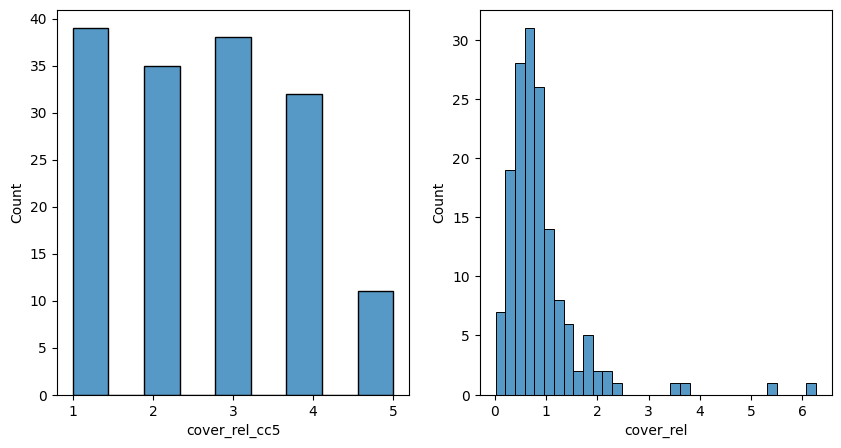

In [189]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(cc5_matches[cc5_matches.burn_severity_median == 2], x='cover_rel_cc5', ax=ax[0])
sns.histplot(cc5_matches[cc5_matches.burn_severity_median == 2], x='cover_rel', ax=ax[1])

<Axes: xlabel='cover_rel', ylabel='Count'>

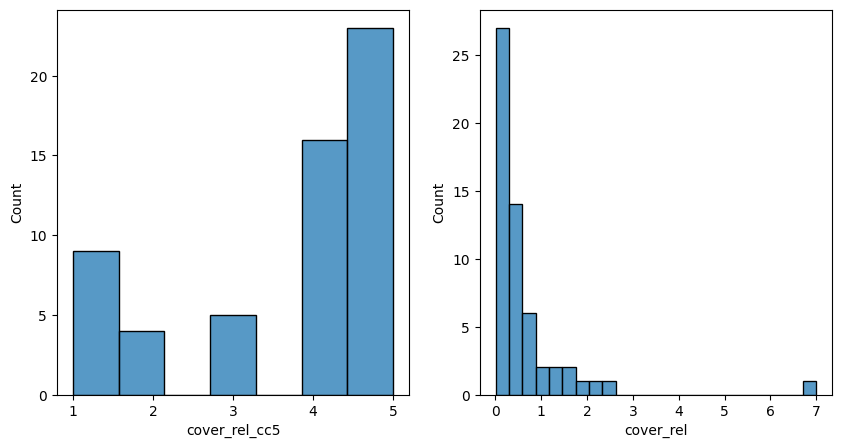

In [190]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(cc5_matches[cc5_matches.burn_severity_median == 3], x='cover_rel_cc5', ax=ax[0])
sns.histplot(cc5_matches[cc5_matches.burn_severity_median == 3], x='cover_rel', ax=ax[1])

<Axes: xlabel='cover_rel', ylabel='Count'>

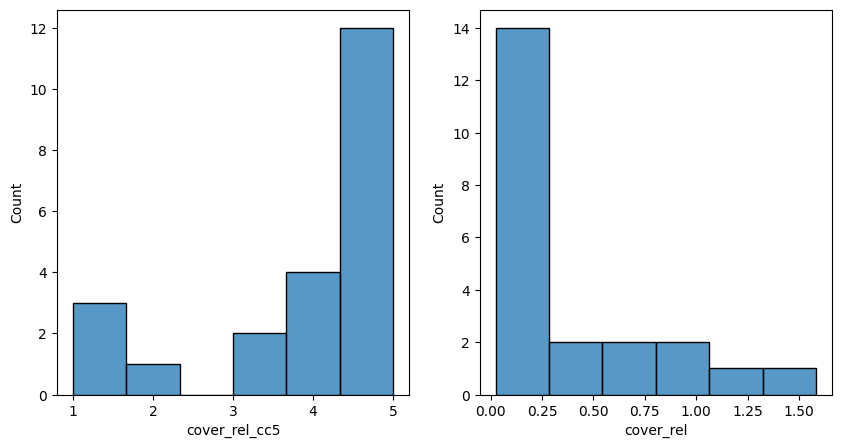

In [191]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(cc5_matches[cc5_matches.burn_severity_median == 4], x='cover_rel_cc5', ax=ax[0])
sns.histplot(cc5_matches[cc5_matches.burn_severity_median == 4], x='cover_rel', ax=ax[1])

<Axes: xlabel='cc5_median', ylabel='Count'>

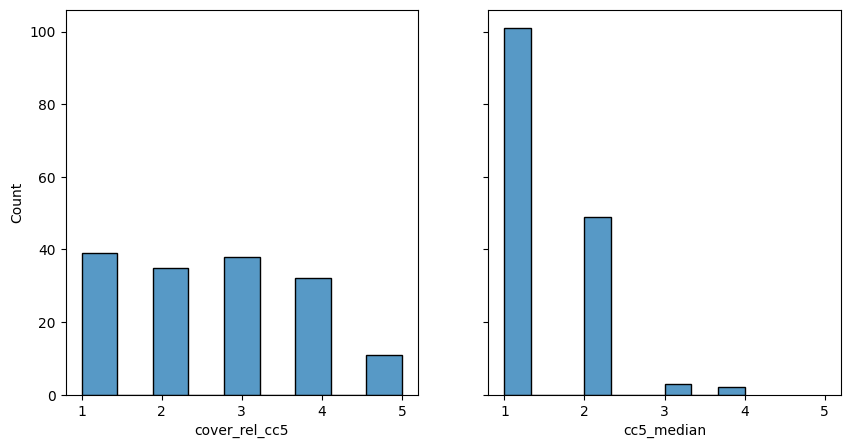

In [193]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)
sns.histplot(cc5_matches[cc5_matches.burn_severity_median == 2], x='cover_rel_cc5', ax=ax[0])
sns.histplot(cc5_matches[cc5_matches.burn_severity_median == 2], x='cc5_median', ax=ax[1])

<Axes: xlabel='cc5_median', ylabel='Count'>

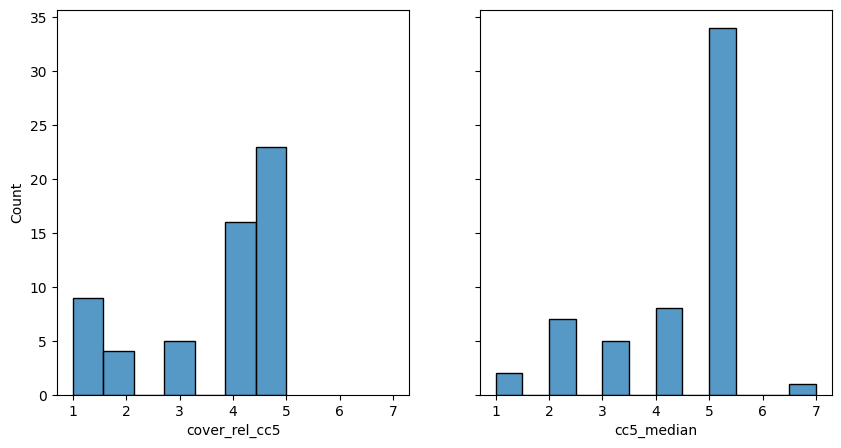

In [192]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)
sns.histplot(cc5_matches[cc5_matches.burn_severity_median == 3], x='cover_rel_cc5', ax=ax[0])
sns.histplot(cc5_matches[cc5_matches.burn_severity_median == 3], x='cc5_median', ax=ax[1])

<Axes: xlabel='cc5_median', ylabel='Count'>

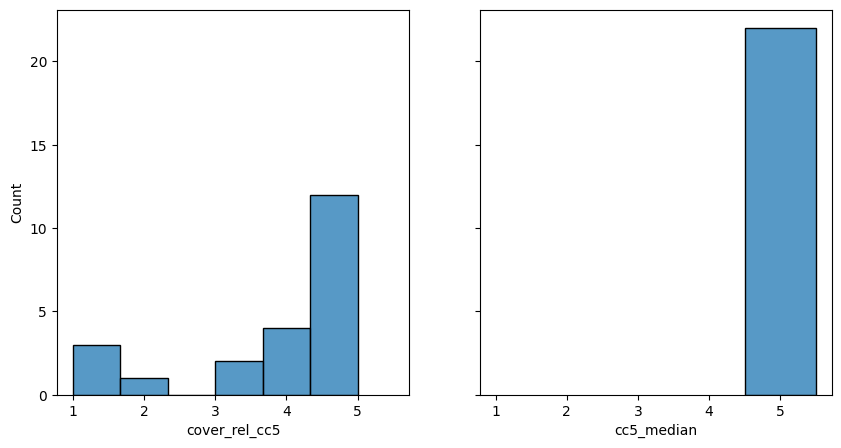

In [194]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, sharex=True)
sns.histplot(cc5_matches[cc5_matches.burn_severity_median == 4], x='cover_rel_cc5', ax=ax[0])
sns.histplot(cc5_matches[cc5_matches.burn_severity_median == 4], x='cc5_median', ax=ax[1])